In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from fastai.vision.all import *
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

'''import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session




"import os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [3]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory
# or Kaggle, which makes some difference for the code below.
try:
    import google.colab
    colab=True
except:
    colab=False

import os
kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [4]:
# This is copied from Howard's notebook: https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data


#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [5]:
# Make sure we're using the latest version of fastai
if colab:
    !pip install -Uqq fastbook
    import fastbook
    fastbook.setup_book()

elif kaggle:
    !pip install -Uqq fastai

In [6]:
from pathlib import Path
if colab:
    from google.colab import drive
    drive.mount("/content/gdrive")
    DATA = Path('/content/gdrive/MyDrive/DAT255/')
    DATA.mkdir(exist_ok=True, parents=True)
    
elif kaggle:
    DATA = Path('/kaggle/input/ansikter/full')
    

In [7]:
DATA.ls()

(#8) [Path('/kaggle/input/ansikter/full/surprise'),Path('/kaggle/input/ansikter/full/fear'),Path('/kaggle/input/ansikter/full/neutral'),Path('/kaggle/input/ansikter/full/sadness'),Path('/kaggle/input/ansikter/full/disgust'),Path('/kaggle/input/ansikter/full/contempt'),Path('/kaggle/input/ansikter/full/happiness'),Path('/kaggle/input/ansikter/full/anger')]

In [8]:
files = get_image_files(DATA)
get_image_files(DATA)[:5]

(#5) [Path('/kaggle/input/ansikter/full/surprise/S085_003_00000013.png'),Path('/kaggle/input/ansikter/full/surprise/S138_004_00000013.png'),Path('/kaggle/input/ansikter/full/surprise/S068_003_00000014.png'),Path('/kaggle/input/ansikter/full/surprise/m06_dfs_p.JPG'),Path('/kaggle/input/ansikter/full/surprise/f13_dfs_p.JPG')]

(640, 490)


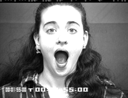

In [9]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)


Looks like the images might be 640x490 -- let's check all their sizes. This is faster if we do it in parallel, so we'll use fastcore's parallel for this:

In [10]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(640, 490)     846
(480, 600)     599
(720, 480)      38
(640, 480)      36
(481, 600)       2
(762, 950)       2
(738, 918)       2
(486, 606)       1
(497, 600)       1
(448, 600)       1
(595, 600)       1
(824, 1027)      1
(480, 604)       1
(731, 913)       1
(482, 600)       1
(480, 599)       1
(744, 930)       1
(480, 602)       1
(516, 600)       1
(486, 600)       1
(491, 600)       1
Name: count, dtype: int64

In [10]:
ansikt = DataBlock(
    blocks=(ImageBlock, CategoryBlock),             # Define data types for the input and output
    get_items=get_image_files,                      # Function to get image files
    splitter=RandomSplitter(valid_pct=0.2, seed=42),# Split data based on grandparent folder name
    get_y=parent_label,                             # Get labels from parent folder names
    item_tfms=Resize(480, method='squish'),                  # Resize images to 480x480 (options: aug_transforms(224), RandomResizedCrop(460))
    batch_tfms=[
        *aug_transforms(size=128, min_scale=0.75),  # Apply some data augmentation (see Chapter 2)
        Normalize.from_stats(*imagenet_stats)       # Normalize image intensities (because pretraining)
    ]
)




In [12]:
dls = ansikt.dataloaders(DATA, bs=64)

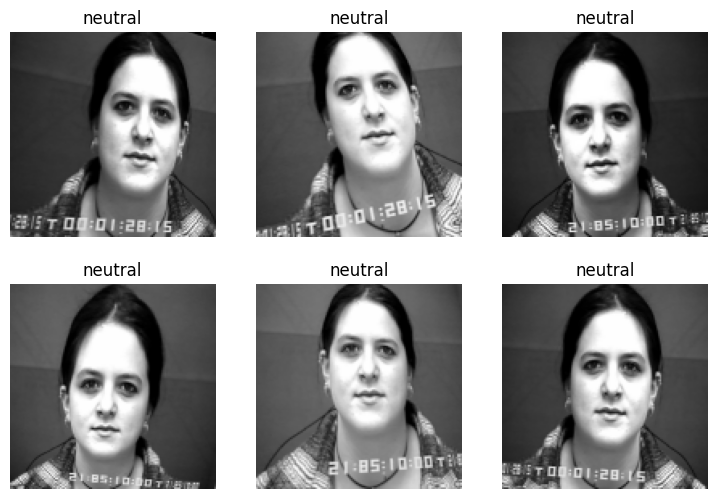

In [13]:
dls.show_batch(max_n=6,unique=True)

In [13]:
learn = vision_learner(dls, resnet34, metrics=error_rate, path='.').to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 235MB/s] 


In [14]:
learn.lr_find(suggest_funcs=(valley,slide))

KeyboardInterrupt: 

In [ ]:
learn.fine_tune(3, 0.01)

In [ ]:
learn.show_results()

In [ ]:
#learn.save('my_model')

In [ ]:
#learn = load('my_model')


In [ ]:
#learn.export('model.pkl')

In [ ]:
# laster inn modellen som blir brukt i huggingface..
#learn = torch.load('/kaggle/input/facescan-modell/pytorch/facescan/1/model.pkl')

## Trying different architectures and preprocessing experiments

In [89]:
def train(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_folder(DATA, seed=42, valid_pct=0.2, item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

### With squish

In [ ]:
# THIS CODE BLOCK IS ONLY FOR ILLUSTRATING HOW THE METHOD IMPACTS IMAGES (WE USE FUNC TRAIN)
dls = ImageDataLoaders.from_folder(DATA, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method='squish')                  # Resize images to 480x480 (options: aug_transforms(224), RandomResizedCrop(460)
                                  )
dls.show_batch(max_n=3)

In [ ]:
learn = train('convnext_small_in22k', item=Resize(480,method='squish'),
              batch=[*aug_transforms(size=128, min_scale=0.75),  # Apply some data augmentation (see Chapter 2)
        Normalize.from_stats(*imagenet_stats)])

### With padding

In [ ]:
# THIS CODE BLOCK IS ONLY FOR ILLUSTRATING HOW THE METHOD IMPACTS IMAGES (WE USE FUNC TRAIN)
dls = ImageDataLoaders.from_folder(DATA, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)              # Resize images to 480x480 (options: aug_transforms(224), RandomResizedCrop(46
    )
dls.show_batch(max_n=3)

In [ ]:
learn = train('convnext_small_in22k', 
              item=Resize(480,method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
              batch=[*aug_transforms(size=128, min_scale=0.75),  # Apply some data augmentation (see Chapter 2)
        Normalize.from_stats(*imagenet_stats)])


### With crop, which is fastAI default

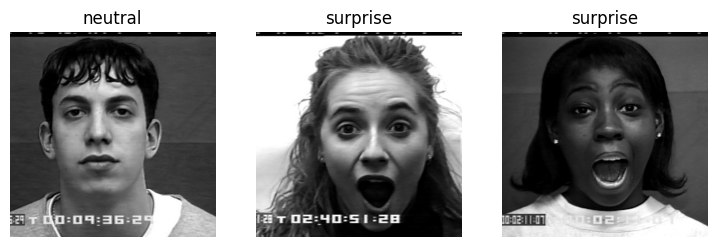

In [12]:
# THIS CODE BLOCK IS ONLY FOR ILLUSTRATING HOW THE METHOD IMPACTS IMAGES (WE USE FUNC TRAIN)
dls = ImageDataLoaders.from_folder(DATA, valid_pct=0.2, seed=42,
    item_tfms=Resize(480)             # Resize images to 480x480 (options: aug_transforms(224), RandomResizedCrop(46
)
dls.show_batch(max_n=3)

In [90]:
learn = train('convnext_small_in22k', 
              item=Resize(480),
              batch=[*aug_transforms(size=128, min_scale=0.75),  # Apply some data augmentation (see Chapter 2)
        Normalize.from_stats(*imagenet_stats)],
             epochs=1)


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.908750,1.704273,0.335505,00:34


epoch,train_loss,valid_loss,error_rate,time
0,0.987967,0.703350,0.208469,00:35


### We see that cropping images gives the lowest error rate in this case

### Let's try to add Test Time Augmentation to see if it improves the error rate

In [149]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)
error_rate(preds, targs)

TensorBase(0.2085)

Here is the augmentation applied to our training set:

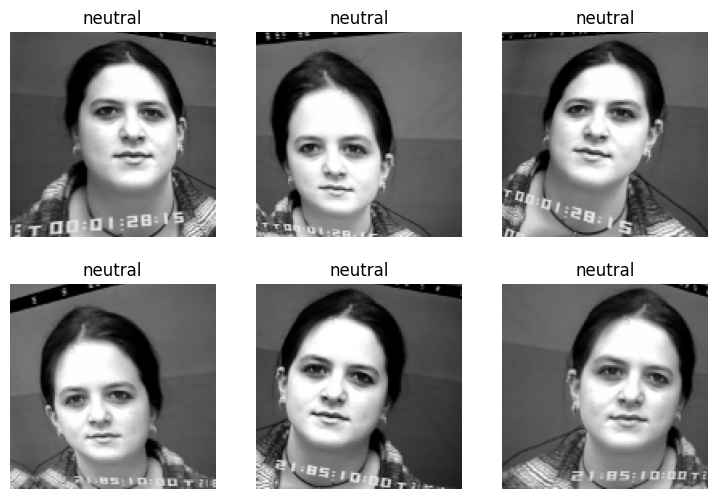

In [143]:
learn.dls.train.show_batch(max_n=6, unique=True)

In [144]:
tta_preds,whatthis = learn.tta(dl=valid)

In [146]:
tta_preds.shape,targs, whatthis.shape

(torch.Size([307, 8]),
 (tensor([[8.8301e-10, 2.2519e-09, 1.9894e-08,  ..., 9.9906e-14, 1.8717e-08,
           1.0000e+00],
          [9.9697e-01, 1.1869e-07, 3.7728e-04,  ..., 4.2141e-06, 2.6491e-03,
           1.7579e-08],
          [1.2051e-04, 7.2967e-05, 5.8739e-04,  ..., 9.9889e-01, 2.2955e-04,
           7.8220e-05],
          ...,
          [1.0706e-04, 5.4719e-03, 9.8583e-01,  ..., 4.5429e-03, 9.5951e-06,
           1.6616e-03],
          [9.9860e-01, 7.9747e-06, 1.9563e-05,  ..., 1.1783e-05, 1.2147e-03,
           1.5767e-07],
          [3.8506e-05, 1.6979e-04, 6.9577e-04,  ..., 9.9863e-01, 6.7383e-05,
           3.8852e-04]]),
  tensor([7, 0, 5, 6, 0, 5, 7, 5, 5, 5, 4, 5, 5, 5, 4, 0, 5, 7, 5, 5, 6, 5, 4, 5,
          3, 1, 5, 7, 1, 2, 1, 5, 5, 3, 2, 5, 1, 5, 5, 5, 3, 5, 5, 5, 5, 5, 2, 7,
          3, 4, 5, 1, 6, 5, 7, 5, 2, 5, 6, 0, 5, 3, 5, 3, 1, 0, 4, 2, 1, 5, 6, 5,
          5, 2, 5, 5, 6, 7, 3, 7, 5, 5, 0, 5, 4, 1, 1, 6, 5, 4, 6, 2, 5, 1, 2, 5,
          2, 3, 1, 1, 5, 6

In [148]:
error_rate(tta_preds, targs)

AssertionError: ==:
307
2456

TTA significantly improved the error rate!

# Renser dataen

In [9]:
import fastai
from fastai.vision.widgets import ImageClassifierCleaner


In [10]:
from PIL import Image

def _open_thumb(
    fn: Path|str, # A path of an image
    h: int, # Thumbnail Height
    w: int # Thumbnail Width
) -> Image: # `PIL` image to display
    "Opens an image path and returns the thumbnail of the image"
    return Image.open(fn).to_thumb(h, w).convert('RGB') # Changed from RGBA to RGB

In [53]:
# Replace the original function
fastai.vision.widgets._open_thumb = _open_thumb

In [54]:
cleaner = ImageClassifierCleaner(learn, max_n = 25)

In [55]:
cleaner

## Trener modellen på nytt med renset data

# Modell-evaluering:

In [139]:
interp = ClassificationInterpretation.from_learner(learn)

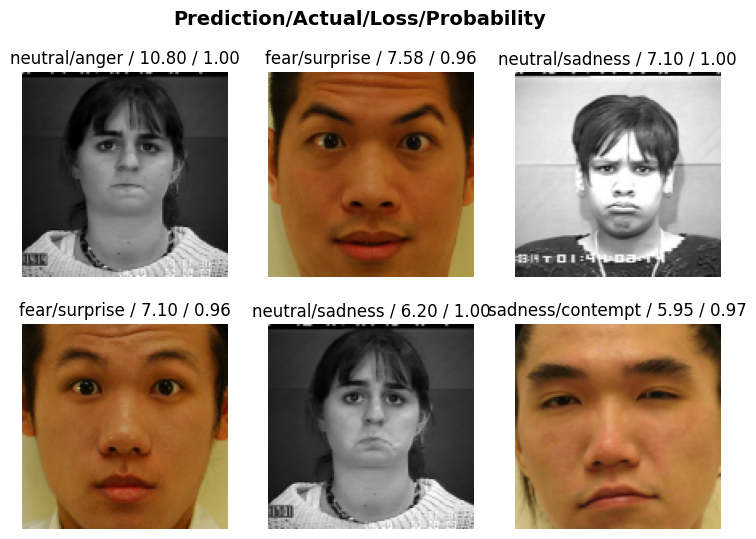

In [140]:
interp.plot_top_losses(6)

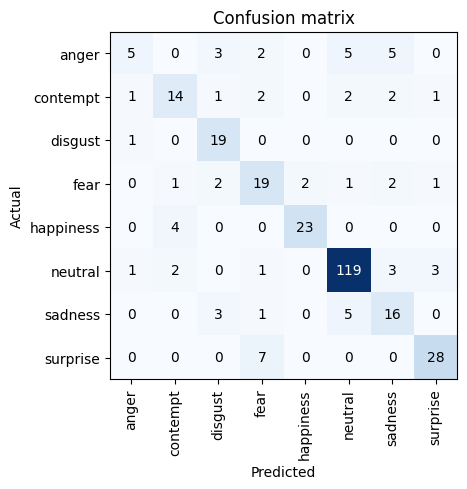

In [141]:
interp.plot_confusion_matrix()

In [142]:
interp.print_classification_report()

              precision    recall  f1-score   support

       anger       0.62      0.25      0.36        20
    contempt       0.67      0.61      0.64        23
     disgust       0.68      0.95      0.79        20
        fear       0.59      0.68      0.63        28
   happiness       0.92      0.85      0.88        27
     neutral       0.90      0.92      0.91       129
     sadness       0.57      0.64      0.60        25
    surprise       0.85      0.80      0.82        35

    accuracy                           0.79       307
   macro avg       0.73      0.71      0.71       307
weighted avg       0.79      0.79      0.78       307



### Let's scale even more up

In [18]:
DATA = Path('/kaggle/input/ansikter/full/fear')

In [125]:
def train(arch, item, batch, epochs=12, accum=1, finetune= True):
    dls = ImageDataLoaders.from_folder(DATA, valid_pct=0.2, item_tfms=item, batch_tfms=batch, bs=64//accum)
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
    if finetune:
        learn.fine_tune(epochs, 0.01)
        return learn.tta(dl=learn.dls.valid)
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, 0.01)



In [126]:
train('convnext_small_in22k', 
              item=Resize(480),
              batch=[*aug_transforms(size=128, min_scale=0.75),  # Apply some data augmentation (see Chapter 2)
                    Normalize.from_stats(*imagenet_stats)],
              epochs = 1,
              accum = 1,
              finetune = False
            
             )


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,4.097716,165.334183,0.908795,00:36


In [16]:
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [12]:
report_gpu()

GPU:0
no processes are running


In [19]:
train('convnext_small_in22k', 
              item=Resize(480),
              batch=[*aug_transforms(size=128, min_scale=0.75),  # Apply some data augmentation (see Chapter 2)
                    Normalize.from_stats(*imagenet_stats)],
              epochs = 1,
              accum = 2,
              finetune = False
             )
report_gpu()

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:03


GPU:0
process       3194 uses     1934.000 MB GPU memory


In [20]:
train('convnext_small_in22k', 
              item=Resize(480),
              batch=[*aug_transforms(size=128, min_scale=0.75),  # Apply some data augmentation (see Chapter 2)
                    Normalize.from_stats(*imagenet_stats)],
              epochs = 1,
              accum = 4,
              finetune = False
             )
report_gpu()

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:06


GPU:0
process       3194 uses     1818.000 MB GPU memory


In [40]:
train('convnext_small_in22k', 
              item=Resize(480),
              batch=[*aug_transforms(size=128, min_scale=0.75),  # Apply some data augmentation (see Chapter 2)
                    Normalize.from_stats(*imagenet_stats)],
              epochs = 1,
              accum = 8,
              finetune = False
             )
report_gpu()

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

### Let's now check some larger models

In [20]:
train('convnext_large_in22k', 
              item=Resize(480),
              batch=[*aug_transforms(size=180, min_scale=0.75),  # Apply some data augmentation (see Chapter 2)
                    Normalize.from_stats(*imagenet_stats)],
              epochs = 1,
              accum = 2,
              finetune = False
             )
report_gpu()

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_large_in22k to current convnext_large.fb_in22k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/919M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.617491,0.611485,0.172638,01:52


epoch,train_loss,valid_loss,error_rate,time
0,0.887122,0.670430,0.214984,02:01


NameError: name 'report_gpu' is not defined

In [25]:

train('vit_large_patch16_224', 
              item=Resize(480),
              batch=[*aug_transforms(size=224, min_scale=0.75),  # Apply some data augmentation (see Chapter 2)
                    Normalize.from_stats(*imagenet_stats)],
              epochs = 1,
              accum = 4,
              finetune = False
             )
report_gpu()

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:06


GPU:0
process       6827 uses    11076.000 MB GPU memory


In [70]:
train('swinv2_large_window12_192_22k', 
              item=Resize(480),
              batch=[*aug_transforms(size=192, min_scale=0.75),  # Apply some data augmentation (see Chapter 2)
                    Normalize.from_stats(*imagenet_stats)],
              epochs = 1,
              accum = 8,
              finetune = False
             )
report_gpu()


epoch,train_loss,valid_loss,error_rate,time


OutOfMemoryError: CUDA out of memory. Tried to allocate 22.00 MiB (GPU 0; 15.89 GiB total capacity; 14.48 GiB already allocated; 30.12 MiB free; 15.08 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Running all models

In [42]:
DATA = Path('/kaggle/input/ansikter/full')

In [17]:
models = {
    'convnext_large_in22k': {
            (*aug_transforms(size=180, min_scale=0.75),  # Apply some data augmentation (see Chapter 2)
                Normalize.from_stats(*imagenet_stats)
            ),
        
    }, 'vit_large_patch16_224': {
        (*aug_transforms(size=224, min_scale=0.75),  # Apply some data augmentation (see Chapter 2)
                    Normalize.from_stats(*imagenet_stats))
    }
}

In [18]:
tta_res = []

for arch,details in models.items():
    for batch in details:
        print('---',arch)
        print(batch)
        tta_res.append(train(arch, item=Resize(480),batch=batch, accum=2))#, epochs=1))
        gc.collect()
        torch.cuda.empty_cache()

--- convnext_large_in22k
(Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: , Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
encodes: (TensorImage,object) -> encodes
decodes: , RandomResizedCropGPU -- {'size': (180, 180), 'min_scale': 0.75, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'max_scale': 1.0, 'mode_mask': 'nearest', 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
(TensorMask,object) -> encodes
decodes: , Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}:
encodes: (TensorImage,object) -> 

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_large_in22k to current convnext_large.fb_in22k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/919M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.508726,1.103669,0.276873,01:52


epoch,train_loss,valid_loss,error_rate,time
0,0.765291,0.487254,0.159609,02:01
1,0.572550,0.349496,0.120521,02:01
2,0.462821,0.387877,0.127036,02:00
3,0.398489,0.432290,0.120521,02:00
4,0.339561,0.323169,0.084691,02:00
5,0.272473,0.265600,0.081433,02:00
6,0.199122,0.205916,0.045603,02:00
7,0.153142,0.198908,0.058632,02:00
8,0.101327,0.197025,0.048860,02:00
9,0.072889,0.183859,0.039088,02:00


--- vit_large_patch16_224
(Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: , Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
encodes: (TensorImage,object) -> encodes
decodes: , RandomResizedCropGPU -- {'size': (224, 224), 'min_scale': 0.75, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'max_scale': 1.0, 'mode_mask': 'nearest', 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
(TensorMask,object) -> encodes
decodes: , Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}:
encodes: (TensorImage,object) ->

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.827037,1.103549,0.325733,00:57


epoch,train_loss,valid_loss,error_rate,time
0,0.752676,0.427540,0.156352,01:18
1,0.527189,0.310964,0.097720,01:18
2,0.470721,0.307044,0.097720,01:19
3,0.407174,0.613941,0.179153,01:19
4,0.339889,0.328703,0.094463,01:18
5,0.264962,0.306854,0.087948,01:19
6,0.250370,0.288602,0.068404,01:18
7,0.183901,0.178302,0.058632,01:19
8,0.142816,0.187388,0.052117,01:18
9,0.097632,0.093963,0.026059,01:19


In [14]:
report_gpu()

NameError: name 'report_gpu' is not defined

In [19]:
tta_res

[(tensor([[1.4660e-06, 9.9979e-01, 1.7756e-07,  ..., 1.5106e-05, 4.6338e-05,
           2.7791e-06],
          [1.2223e-06, 1.3012e-06, 5.5639e-06,  ..., 9.9999e-01, 5.2244e-07,
           1.0105e-06],
          [8.4054e-07, 2.8544e-05, 1.1938e-05,  ..., 9.9976e-01, 1.5848e-04,
           2.3064e-05],
          ...,
          [3.8846e-10, 9.0551e-11, 4.6296e-08,  ..., 9.0491e-10, 3.7872e-08,
           1.0000e+00],
          [9.6729e-04, 6.0758e-02, 2.3316e-06,  ..., 9.3187e-01, 5.8584e-03,
           7.9719e-05],
          [9.6220e-07, 1.4430e-05, 2.1406e-05,  ..., 9.9994e-01, 2.5302e-07,
           4.4927e-06]]),
  tensor([1, 5, 5, 5, 2, 5, 5, 6, 0, 5, 5, 3, 5, 5, 5, 5, 5, 1, 1, 5, 5, 7, 5, 4,
          5, 5, 6, 5, 7, 1, 1, 4, 5, 5, 5, 7, 3, 5, 5, 0, 5, 1, 5, 5, 5, 4, 0, 5,
          4, 5, 5, 5, 5, 0, 1, 1, 6, 5, 4, 5, 5, 5, 1, 5, 2, 0, 5, 0, 3, 4, 5, 6,
          2, 5, 7, 7, 5, 5, 1, 5, 3, 0, 5, 5, 5, 5, 3, 4, 5, 7, 5, 5, 5, 1, 5, 0,
          5, 7, 3, 2, 3, 3, 1, 0, 4, 0, 5, 3, 0, 

In [121]:
save_pickle('tta_res1.pkl', tta_res)

In [110]:

tta_prs = load_pickle('/kaggle/working/tta_res.pkl')

In [111]:
tta_prs = first(zip(*tta_res))
tta_prs

(tensor([[9.9984e-01, 8.2345e-07, 1.4515e-04,  ..., 2.2706e-07, 1.1889e-05,
          1.6432e-06],
         [4.5828e-06, 3.9201e-06, 8.3031e-07,  ..., 9.9998e-01, 1.2201e-05,
          2.8723e-07],
         [6.3891e-04, 1.6935e-05, 3.2947e-06,  ..., 9.9925e-01, 3.9626e-06,
          1.5071e-05],
         ...,
         [2.2327e-06, 1.2336e-05, 9.6084e-07,  ..., 2.9188e-06, 9.9869e-01,
          1.1164e-07],
         [2.1033e-06, 2.2301e-06, 4.0491e-07,  ..., 9.9999e-01, 9.2015e-07,
          1.1753e-06],
         [1.4137e-08, 8.7199e-08, 2.9805e-09,  ..., 6.0933e-11, 8.4808e-11,
          5.6296e-10]]),
 tensor([[8.8301e-10, 2.2519e-09, 1.9894e-08,  ..., 9.9906e-14, 1.8717e-08,
          1.0000e+00],
         [9.9697e-01, 1.1869e-07, 3.7728e-04,  ..., 4.2141e-06, 2.6491e-03,
          1.7579e-08],
         [1.2051e-04, 7.2967e-05, 5.8739e-04,  ..., 9.9889e-01, 2.2955e-04,
          7.8220e-05],
         ...,
         [1.0706e-04, 5.4719e-03, 9.8583e-01,  ..., 4.5429e-03, 9.5951e-06,
   

In [114]:
avg_pr = torch.stack(tta_prs).mean(0)
avg_pr.shape

torch.Size([307, 8])

In [116]:
idxs = avg_pr.argmax(dim=1)
idxs

tensor([7, 5, 5, 1, 0, 2, 2, 4, 4, 5, 4, 5, 5, 0, 4, 5, 4, 7, 5, 2, 7, 5, 4, 2,
        3, 2, 5, 7, 1, 4, 1, 5, 5, 0, 4, 5, 4, 7, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 3, 5, 4, 7, 6, 5, 2, 4, 4, 4, 1, 4, 5,
        5, 2, 5, 5, 5, 2, 7, 7, 5, 5, 0, 5, 4, 1, 5, 5, 7, 4, 1, 4, 5, 5, 2, 7,
        5, 1, 7, 1, 5, 6, 5, 5, 5, 5, 5, 4, 5, 5, 5, 4, 6, 4, 5, 5, 6, 3, 7, 5,
        0, 6, 5, 5, 7, 5, 7, 4, 3, 3, 5, 5, 5, 7, 6, 2, 4, 5, 7, 5, 2, 0, 5, 5,
        0, 5, 7, 7, 0, 5, 0, 6, 7, 3, 5, 4, 4, 5, 5, 0, 1, 5, 2, 7, 5, 5, 5, 5,
        5, 5, 3, 5, 6, 5, 3, 5, 5, 1, 5, 2, 2, 2, 5, 5, 2, 1, 4, 1, 5, 0, 2, 4,
        6, 5, 0, 5, 5, 5, 5, 5, 4, 4, 7, 5, 5, 5, 7, 7, 4, 5, 7, 7, 5, 7, 5, 1,
        5, 5, 5, 7, 3, 2, 6, 5, 6, 5, 5, 2, 5, 6, 4, 7, 5, 7, 7, 5, 5, 5, 5, 1,
        5, 0, 4, 1, 5, 5, 4, 3, 5, 0, 6, 1, 5, 5, 0, 4, 5, 2, 7, 6, 2, 5, 2, 4,
        4, 7, 5, 5, 4, 4, 4, 7, 6, 2, 5, 5, 5, 5, 0, 5, 3, 7, 7, 5, 5, 4, 5, 2,
        2, 2, 1, 5, 4, 5, 5, 4, 5, 4, 5,

In [117]:
error_rate(avg_pr,idxs)

TensorBase(0.)

## Aktiveringskart

In [63]:
!pip install -Uqq fastai_amalgam palettable matplotlib_venn



In [64]:
from notebookb4ed0a1743 import *
from fastai.vision import *

In [65]:
val_images = dls.valid.items
val_images[:3]

[Path('/kaggle/input/ansikter/full/neutral/S037_001_00000001.png'),
 Path('/kaggle/input/ansikter/full/neutral/m13_dfh_nx.jpg'),
 Path('/kaggle/input/ansikter/full/neutral/S066_003_00000001.png')]

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

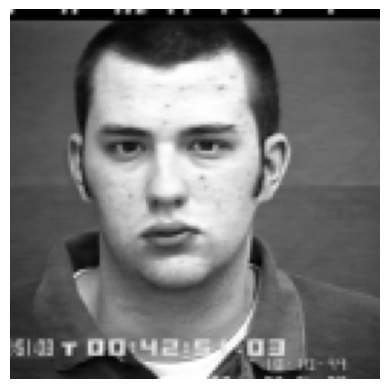

In [67]:
for img_fn in random.choices(val_images, k=4):
    gcam = gradcam(learn, str(DATA/img_fn), show_original=True)
    f = plt.figure(figsize=(8,6))
    plt.imshow(gcam)
    plt.axis('off')
    plt.show()

# Tester på egne bilder

Predicted emotion: surprise
Predictions index: 7
Probabilities: tensor([6.3314e-06, 2.2841e-06, 9.1803e-03, 1.4641e-02, 1.8997e-04, 8.4994e-09,
        3.5708e-04, 9.7562e-01])


<Axes: >

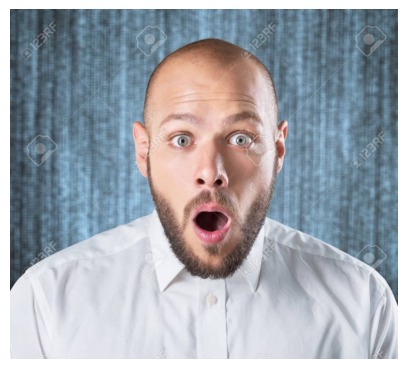

In [127]:
# Eget bilde
img = PILImage.create('/kaggle/input/ansikter/bilder/img4.jpg')

# Get predictions
pred_class, pred_idx, outputs = learn.predict(img)

# Print results
print(f'Predicted emotion: {pred_class}')
print(f'Predictions index: {pred_idx}')
print(f'Probabilities: {outputs}')

img.show()

Predicted emotion: happiness
Predictions index: 4
Probabilities: tensor([5.5338e-06, 1.8562e-03, 8.0528e-05, 4.1250e-05, 9.6437e-01, 9.7281e-08,
        1.1418e-07, 3.3650e-02])


"gcam = gradcam(learn, str(Path('/kaggle/input/ansikter/bilder/img2.jpg')), show_original=True)\nf = plt.figure(figsize=(8,6))\nplt.imshow(gcam)\nplt.axis('off')\nplt.show()"

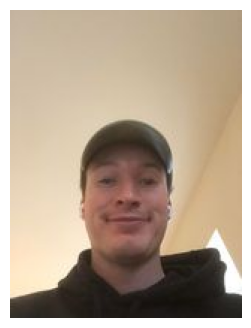

In [128]:
# Eget bilde
img1 = PILImage.create('/kaggle/input/ansikter/bilder/img2.jpg')

# Get predictions (no need to apply after_batch transforms explicitly, predict does that)
pred_class, pred_idx, outputs = learn.predict(img1)

# Print results
print(f'Predicted emotion: {pred_class}')
print(f'Predictions index: {pred_idx}')
print(f'Probabilities: {outputs}')

# Show the image
img1.show()
'''gcam = gradcam(learn, str(Path('/kaggle/input/ansikter/bilder/img2.jpg')), show_original=True)
f = plt.figure(figsize=(8,6))
plt.imshow(gcam)
plt.axis('off')
plt.show()'''

Predicted emotion: surprise
Predictions index: 7
Probabilities: tensor([2.7754e-05, 2.7270e-05, 3.9773e-02, 1.2491e-02, 2.6737e-03, 1.7570e-06,
        3.2766e-05, 9.4497e-01])


"gcam = gradcam(learn, str(Path('/kaggle/input/ansikter/bilder/img3.jpg')), show_original=True)\nf = plt.figure(figsize=(8,6))\nplt.imshow(gcam)\nplt.axis('off')\nplt.show()"

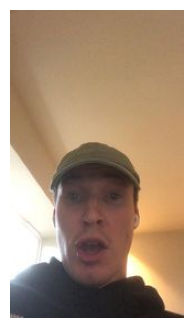

In [129]:
# Eget bilde
img1 = PILImage.create('/kaggle/input/ansikter/bilder/img3.jpg')

# Get predictions (no need to apply after_batch transforms explicitly, predict does that)
pred_class, pred_idx, outputs = learn.predict(img1)

# Print results
print(f'Predicted emotion: {pred_class}')
print(f'Predictions index: {pred_idx}')
print(f'Probabilities: {outputs}')

# Show the image
# Show the image
img1.show()
'''gcam = gradcam(learn, str(Path('/kaggle/input/ansikter/bilder/img3.jpg')), show_original=True)
f = plt.figure(figsize=(8,6))
plt.imshow(gcam)
plt.axis('off')
plt.show()'''

Predicted emotion: happiness
Predictions index: 4
Probabilities: tensor([3.2032e-04, 1.1616e-02, 3.0600e-03, 3.9968e-03, 9.7941e-01, 2.7394e-05,
        4.8843e-04, 1.0773e-03])


"gcam = gradcam(learn, str(Path('/kaggle/input/bilder/Photo.jpg')), show_original=True)\nf = plt.figure(figsize=(8,6))\nplt.imshow(gcam)\nplt.axis('off')\nplt.show()"

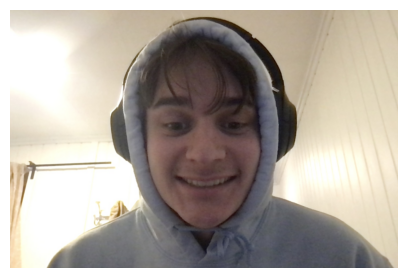

In [130]:
# Eget bilde
img1 = PILImage.create('/kaggle/input/bilder/Photo.jpg')

# Get predictions (no need to apply after_batch transforms explicitly, predict does that)
pred_class, pred_idx, outputs = learn.predict(img1)

# Print results
print(f'Predicted emotion: {pred_class}')
print(f'Predictions index: {pred_idx}')
print(f'Probabilities: {outputs}')
# Show the image
img1.show()
# Show the image
'''gcam = gradcam(learn, str(Path('/kaggle/input/bilder/Photo.jpg')), show_original=True)
f = plt.figure(figsize=(8,6))
plt.imshow(gcam)
plt.axis('off')
plt.show()'''

Predicted emotion: sadness
Predictions index: 6
Probabilities: tensor([0.0101, 0.0095, 0.2962, 0.0128, 0.0103, 0.0007, 0.6590, 0.0014])


<Axes: >

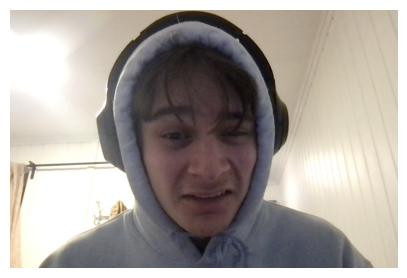

In [131]:
# Eget bilde
img1 = PILImage.create('/kaggle/input/bilder/Photo2.jpg')

# Get predictions (no need to apply after_batch transforms explicitly, predict does that)
pred_class, pred_idx, outputs = learn.predict(img1)

# Print results
print(f'Predicted emotion: {pred_class}')
print(f'Predictions index: {pred_idx}')
print(f'Probabilities: {outputs}')

# Show the image
img1.show()

Predicted emotion: neutral
Predictions index: 5
Probabilities: tensor([6.1823e-02, 1.5005e-01, 2.6759e-02, 3.8948e-03, 2.7803e-04, 7.3571e-01,
        2.1282e-02, 1.9296e-04])


"gcam = gradcam(learn, str(Path('/kaggle/input/bilder/samuelpic.jpg')), show_original=True)\nf = plt.figure(figsize=(8,6))\nplt.imshow(gcam)\nplt.axis('off')\nplt.show()"

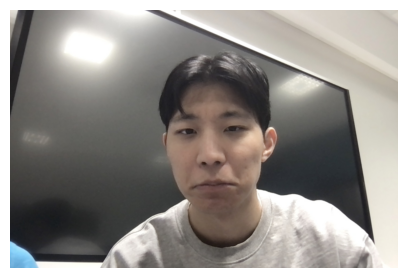

In [132]:
# Eget bilde
img1 = PILImage.create('/kaggle/input/bilder/samuelpic.jpg')

# Get predictions (no need to apply after_batch transforms explicitly, predict does that)
pred_class, pred_idx, outputs = learn.predict(img1)

# Print results
print(f'Predicted emotion: {pred_class}')
print(f'Predictions index: {pred_idx}')
print(f'Probabilities: {outputs}')
img1.show()
# Show the image
'''gcam = gradcam(learn, str(Path('/kaggle/input/bilder/samuelpic.jpg')), show_original=True)
f = plt.figure(figsize=(8,6))
plt.imshow(gcam)
plt.axis('off')
plt.show()'''

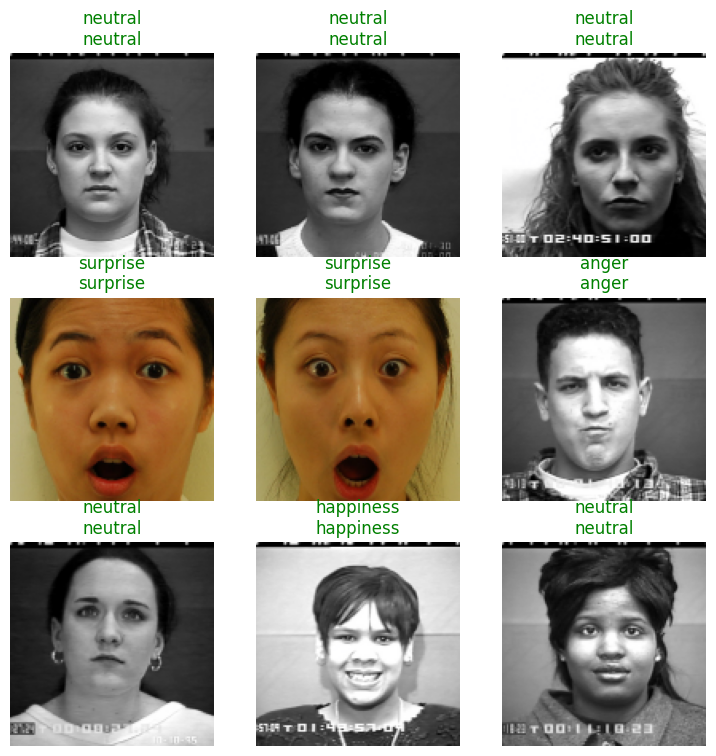

In [138]:
learn.show_results()